In [156]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D, Dense, RandomFlip# type: ignore
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import VGG16

from sklearn.metrics import confusion_matrix
main_path = "C:\\Users\\munod\\OneDrive\\Documents\\Datasets\\BreastUltrasound\\Dataset_BUSI_with_GT"
directories = os.listdir(main_path)
images = []
labels = []
for direct in directories:
    #print(direct)
    files = os.listdir(main_path+"\\"+direct)
    if direct == "normal":
        code = 0
    elif direct == "benign":
        code = 1
    else:
        code = 2
    for file in files:
        if not file.endswith("_mask.png"):
            img = cv2.imread(main_path+"\\"+direct+"\\"+file)
            img = cv2.resize(img, (400,400))
            label_array = [0,0,0]
            label_array[code] = 1
            labels.append(label_array)
            images.append(img)


In [157]:
images = np.asarray(images)
labels = np.asarray(labels)
display("Shape of Images" , images.shape, "Label Shape", labels.shape)

'Shape of Images'

(798, 400, 400, 3)

'Label Shape'

(798, 3)

In [158]:
data = images/255.0

In [159]:
X_train,X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True)


In [160]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(400, 400, 3))

In [161]:
num_classes = 3

x = base_model.output
print(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

<KerasTensor shape=(None, 12, 12, 512), dtype=float32, sparse=False, name=keras_tensor_376>


In [162]:
for layer in model.layers[:-3]:
    layer.trainable = False
    

In [165]:
model = Sequential(
    [
        RandomFlip("horizontal"),
        model,
    ]
)

In [166]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [167]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 348s 17s/step - accuracy: 0.4602 - loss: 0.0000e+00
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 315s 16s/step - accuracy: 0.7886 - loss: 0.0000e+00
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 263s 13s/step - accuracy: 0.8535 - loss: 0.0000e+00
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 263s 13s/step - accuracy: 0.8416 - loss: 0.0000e+00
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 255s 13s/step - accuracy: 0.8875 - loss: 0.0000e+00
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 267s 13s/step - accuracy: 0.9250 - loss: 0.0000e+00
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 271s 14s/step - accuracy: 0.9680 - loss: 0.0000e+00
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 271s 14s/step - accuracy: 0.9645 - loss: 0.0000e+00
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 268s 13s/step - accuracy: 0.9932 - loss: 0.0000e+00
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 273s 14s/step - accuracy: 0.9935 - loss: 0.0000e+00


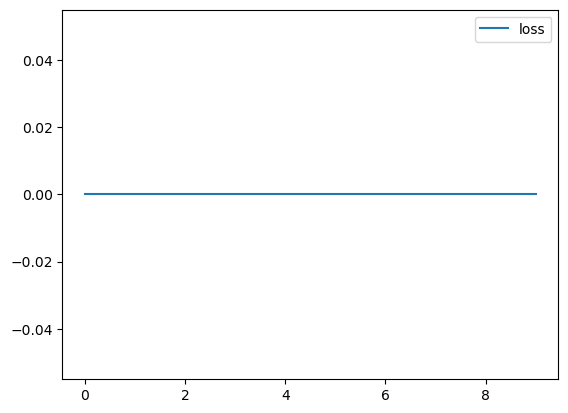

In [168]:
plt.plot(model.history.history['loss'], label='loss')
plt.legend()
plt.show()

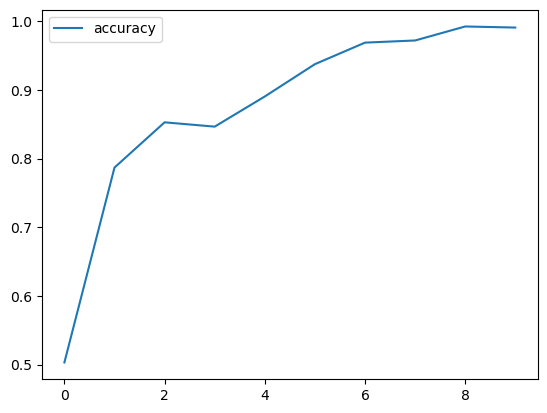

In [169]:
plt.plot(model.history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

In [171]:
result = model.evaluate(X_test, y_test, batch_size=32)
print(result)

print(f'The accuracy is {accuracy}')
print(f'The loss is {loss}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 56s 12s/step - accuracy: 0.8052 - loss: 0.0000e+00
[0.0, 0.0, 0.8062499761581421, 0.8062499761581421]
The accuracy is 0.824999988079071
The loss is 0.5324912071228027


In [172]:
from sklearn.metrics import roc_auc_score, roc_curve, auc


y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 60s 13s/step


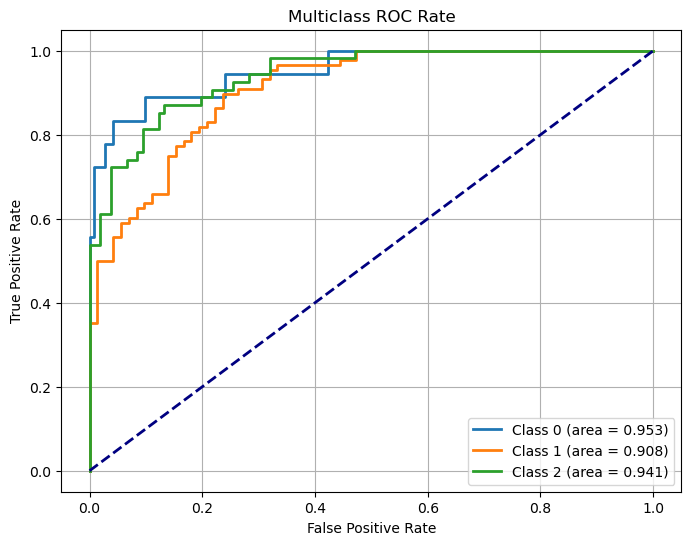

AUROC for class Normal : 0.953
AUROC for class Benign : 0.908
AUROC for class Malignant : 0.941


In [173]:
y_true = y_test
n_classes = y_true.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i],  _ =  roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i],tpr[i])

plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i], 
        lw=2,
        label=f"Class {i} (area = {roc_auc[i]:.3f})"

    )

plt.plot([0,1], [0,1], color="navy", lw=2, linestyle= "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()
classes_names = {0:"Normal", 1:"Benign", 2:"Malignant"}
for i in range(n_classes):
    print(f"AUROC for class {classes_names[i]} : {roc_auc[i]:.3f}")


In [174]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_11 (RandomFlip)     │ (None, 400, 400, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_15 (Functional)      │ (None, 3)              │    33,590,083 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,340,875 (272.14 MB)

 Trainable params: 18,875,395 (72.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 37,750,792 (144.01 MB)

In [175]:
model.save("breast_uss_normal_bening_malignant_vgg16_model.keras")

In [176]:
from tensorflow.keras.models import load_model
model = load_model("breast_uss_normal_bening_malignant_vgg16_model.keras")